In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [11]:
#load dataset
data = pd.read_csv("ml_dataset.csv")
data.head

<bound method NDFrame.head of        age          worklass  fnlwgt   education  education-num  \
0       39         State-gov   77516   Bachelors             13   
1       50  Self-emp-not-inc   83311   Bachelors             13   
2       38           Private  215646     HS-grad              9   
3       53           Private  234721        11th              7   
4       28           Private  338409   Bachelors             13   
...    ...               ...     ...         ...            ...   
32556   27           Private  257302  Assoc-acdm             12   
32557   40           Private  154374     HS-grad              9   
32558   58           Private  151910     HS-grad              9   
32559   22           Private  201490     HS-grad              9   
32560   52      Self-emp-inc  287927     HS-grad              9   

           martial-status         occupation   relationship   race     sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Ma

In [12]:
#Investigate class balance
data['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [13]:
#Investigate data types
data.dtypes

age                int64
worklass          object
fnlwgt             int64
education         object
education-num      int64
martial-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
id                 int64
dtype: object

In [14]:
#Investigate null values
data.isnull().sum()

age               0
worklass          0
fnlwgt            0
education         0
education-num     0
martial-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
id                0
dtype: int64

In [15]:
#Util functions, normalization and standardization

def normalize(data,column):
    data[column] = (data[column] - np.min(data[column])) / (np.max(data[column]) - np.min(data[column])) 
    return data
    
def standardize(data,column):
    data[column] = (data[column] - np.mean(data[column])) / np.std(data[column])
    return data
    

In [16]:
#load the dataset
data = pd.read_csv("ml_dataset.csv")

#transform string data into numeric data, one-hot encoded
data = pd.get_dummies(data,drop_first = True)


#normalize and standardize data
for column in data.columns:
    if data[column].dtype == "int64":
        data = standardize(data,column)
        data = normalize(data,column)
    

        
#define input data, drop targets and irrelevant datapoints
train = data.drop(['income_>50K',"id"], axis = 1)
#define target; 0: income>50K, 1: income<50K
test = data['income_>50K']

#Split data in train, validation and test set
x_train, x_val_test,y_train, y_val_test = train_test_split(train,test,test_size = 0.3, random_state= 123)

x_val, x_test, y_val, y_test = train_test_split(x_val_test,y_val_test,test_size = 0.5, random_state= 123)

#Create stratified folds for cross-validation
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)

In [17]:
#Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train,y_train)
print('Logistic Regression \nAccuracy',logreg.score(x_test,y_test))

Logistic Regression 
Accuracy 0.8519959058341863


Logistic Regression


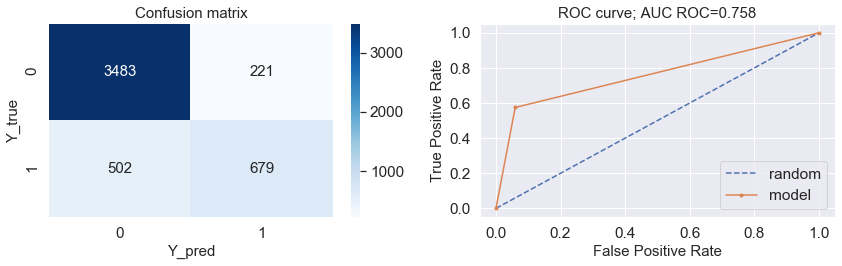

In [18]:
#Results Logistic Regression
print('Logistic Regression')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

#Generate Predictions
y_pred = logreg.predict(x_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g', ax = ax1,cmap=plt.cm.Blues) # font size
ax1.set_title('Confusion matrix', fontsize = 15)
ax1.set_xlabel('Y_pred', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Y_true', fontsize = 15) # y-axis label with fontsize 15


##ROC AUC
# generate a no skill prediction (majority class)
y_pred_rd = [0 for _ in range(len(y_test))]

#Calculate scores
rd_auc = roc_auc_score(y_test, y_pred_rd )
model_auc = roc_auc_score(y_test, y_pred)


# calculate roc curves
rd_fpr, rd_tpr, _ = roc_curve(y_test, y_pred_rd, pos_label= 1)
model_fpr, model_tpr, model_thresholds = roc_curve(y_test, y_pred, pos_label = 1)
# plot the roc curve for the model
ax2.plot(rd_fpr, rd_tpr, linestyle='--', label='random')
ax2.plot(model_fpr, model_tpr, marker='.', label='model')
ax2.set_xlabel('False Positive Rate', fontsize = 15)
ax2.set_ylabel('True Positive Rate', fontsize = 15)
ax2.set_title(f'ROC curve; AUC ROC=%.3f' % model_auc, fontsize = 15)
ax2.legend(loc='lower right')
plt.tight_layout()


In [19]:
#Logistic Regression with cross-validation
logreg = LogisticRegression(max_iter=1000)
scores = cross_val_score(logreg, train, test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Logistic Regression CV \nAccuracy: '+ str(np.round(np.mean(scores),3)) + ' Std: '+ str(np.round(np.std(scores), 4)))

Logistic Regression CV 
Accuracy: 0.851 Std: 0.0049


In [20]:
#Classification Tree

clf = tree.DecisionTreeClassifier()
clf.fit(x_train,y_train)
print("Classification Tree \nAccuracy", clf.score(x_test,y_test))

Classification Tree 
Accuracy 0.8231320368474924


Classification Tree


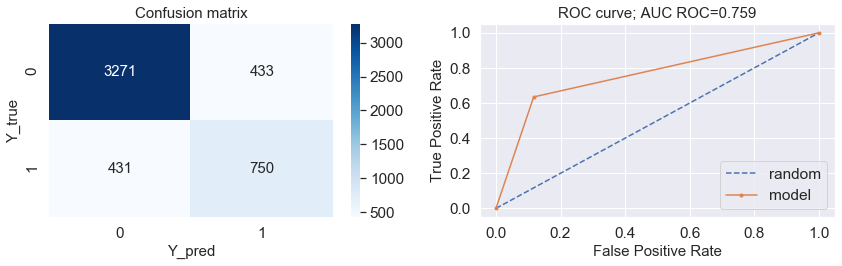

In [21]:
#Results Classification Tree
print("Classification Tree")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

#Generate predictions
y_pred = clf.predict(x_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g', ax = ax1,cmap=plt.cm.Blues) # font size
ax1.set_title('Confusion matrix', fontsize = 15)
ax1.set_xlabel('Y_pred', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Y_true', fontsize = 15) # y-axis label with fontsize 15


##ROC AUC
# generate a no skill prediction (majority class)
y_pred_rd = [0 for _ in range(len(y_test))]

# calculate scores
rd_auc = roc_auc_score(y_test, y_pred_rd )
model_auc = roc_auc_score(y_test, y_pred)


# calculate roc curves
rd_fpr, rd_tpr, _ = roc_curve(y_test, y_pred_rd, pos_label= 1)
model_fpr, model_tpr, model_thresholds = roc_curve(y_test, y_pred, pos_label = 1)
# plot the roc curve for the model
ax2.plot(rd_fpr, rd_tpr, linestyle='--', label='random')
ax2.plot(model_fpr, model_tpr, marker='.', label='model')
ax2.set_xlabel('False Positive Rate', fontsize = 15)
ax2.set_ylabel('True Positive Rate', fontsize = 15)
ax2.set_title(f'ROC curve; AUC ROC=%.3f' % model_auc, fontsize = 15)
ax2.legend(loc='lower right')
plt.tight_layout()


In [22]:
#Classification Tree with stratified cross-validation
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, train, test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Classification Tree CV \nAccuracy: '+ str(np.round(np.mean(scores),3)) + ' Std: '+ str(np.round(np.std(scores), 4)))

Classification Tree CV 
Accuracy: 0.814 Std: 0.0053


In [23]:
#Random Forest Classifier 
rforest = RandomForestClassifier()
rforest.fit(x_train,y_train)
print("Random Forest \nAccuracy", rforest.score(x_test,y_test))

Random Forest 
Accuracy 0.858546571136131


Random Forest


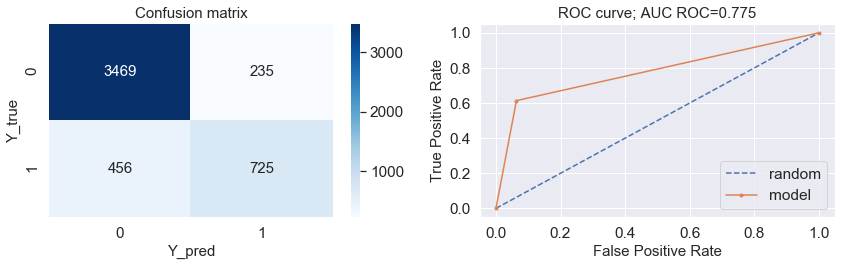

In [24]:
#Results Random Forest Classifier
print("Random Forest")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


#Generate predictions
y_pred = rforest.predict(x_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g', ax = ax1,cmap=plt.cm.Blues) # font size
ax1.set_title('Confusion matrix', fontsize = 15)
ax1.set_xlabel('Y_pred', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Y_true', fontsize = 15) # y-axis label with fontsize 15


##ROC AUC
# generate a no skill prediction (majority class)
y_pred_rd = [0 for _ in range(len(y_test))]

# calculate scores
rd_auc = roc_auc_score(y_test, y_pred_rd )
model_auc = roc_auc_score(y_test, y_pred)


# calculate roc curves
rd_fpr, rd_tpr, _ = roc_curve(y_test, y_pred_rd, pos_label= 1)
model_fpr, model_tpr, model_thresholds = roc_curve(y_test, y_pred, pos_label = 1)
# plot the roc curve for the model
ax2.plot(rd_fpr, rd_tpr, linestyle='--', label='random')
ax2.plot(model_fpr, model_tpr, marker='.', label='model')
ax2.set_xlabel('False Positive Rate', fontsize = 15)
ax2.set_ylabel('True Positive Rate', fontsize = 15)
ax2.set_title(f'ROC curve; AUC ROC=%.3f' % model_auc, fontsize = 15)
ax2.legend(loc='lower right')
plt.tight_layout()

In [25]:
#Random Forest Classifier with cross-validation
rforest = RandomForestClassifier()
scores = cross_val_score(rforest, train, test, scoring='accuracy', cv=cv, n_jobs=-1)

print('Random Forest CV \nAccuracy: '+ str(np.round(np.mean(scores),3)) + ' Std: '+ str(np.round(np.std(scores), 4)))

Random Forest CV 
Accuracy: 0.854 Std: 0.0034


In [26]:
#Neural Network
print("Neural Network")

# define the keras model
model = Sequential()
model.add(Dense(64, input_dim=np.shape(x_train)[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# compile the keras model
#optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1,
                                          mode='min', min_delta=0, cooldown=0, min_lr=0)

my_checkpoints =[reduce_lr,
                keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=15)]

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_metric = get_lr_metric(optimizer)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])

#class weight due to address class imblance

# calculate class weight with sklearn
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=np.array(data['income_>50K'].to_list()))
class_weights_dict = dict(enumerate(class_weights))

# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=100, batch_size=32, callbacks = my_checkpoints,verbose = 1,class_weight=class_weights_dict)


Neural Network
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 22792 samples, validate on 4884 samples
Epoch 1/100
22792/22792 [==============================] - 2s 73us/sample - loss: 1.1421 - acc: 0.5930 - lr: 1.0000e-04 - val_loss: 0.8779 - val_acc: 0.7162 - val_lr: 1.0000e-04
Epoch 2/100
22792/22792 [==============================] - 1s 56us/sample - loss: 0.7454 - acc: 0.7349 - lr: 1.0000e-04 - val_loss: 0.6366 - val_acc: 0.7330 - val_lr: 1.0000e-04
Epoch 3/100
22792/22792 [==============================] - 1s 58us/sample - loss: 0.6058 - acc: 0.7460 - lr: 1.0000e-04 - val_loss: 0.5717 - val_acc: 0.7379 - val_lr: 1.0000e-04
Epoch 4/100
22792/22792 [==============================] - 1s 60us/sample - loss: 0.5463 - acc: 0.7564 - lr: 1.0000e-04 - val_loss: 0.5384 - val_acc: 0.7465 - val_lr: 1.0000e-04
Epoch 5/100


22792/22792 [==============================] - 1s 61us/sample - loss: 0.3976 - acc: 0.8039 - lr: 2.5000e-05 - val_loss: 0.4199 - val_acc: 0.7903 - val_lr: 2.5000e-05
Epoch 41/100
22792/22792 [==============================] - 1s 60us/sample - loss: 0.3967 - acc: 0.8055 - lr: 2.5000e-05 - val_loss: 0.4038 - val_acc: 0.8006 - val_lr: 2.5000e-05
Epoch 42/100
22792/22792 [==============================] - 1s 62us/sample - loss: 0.3946 - acc: 0.8062 - lr: 2.5000e-05 - val_loss: 0.4058 - val_acc: 0.8006 - val_lr: 2.5000e-05
Epoch 43/100
22080/22792 [============================>.] - ETA: 0s - loss: 0.3963 - acc: 0.8057 - lr: 2.5000e-05
Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
22792/22792 [==============================] - 1s 59us/sample - loss: 0.3955 - acc: 0.8066 - lr: 2.5000e-05 - val_loss: 0.4058 - val_acc: 0.7993 - val_lr: 2.5000e-05


Neural Network
4885/4885 [==============================] - 0s 24us/sample - loss: 0.3960 - acc: 0.8115 - lr: 1.2500e-05
Test loss: 0.396002771093023 / Test accuracy: 0.8114636540412903


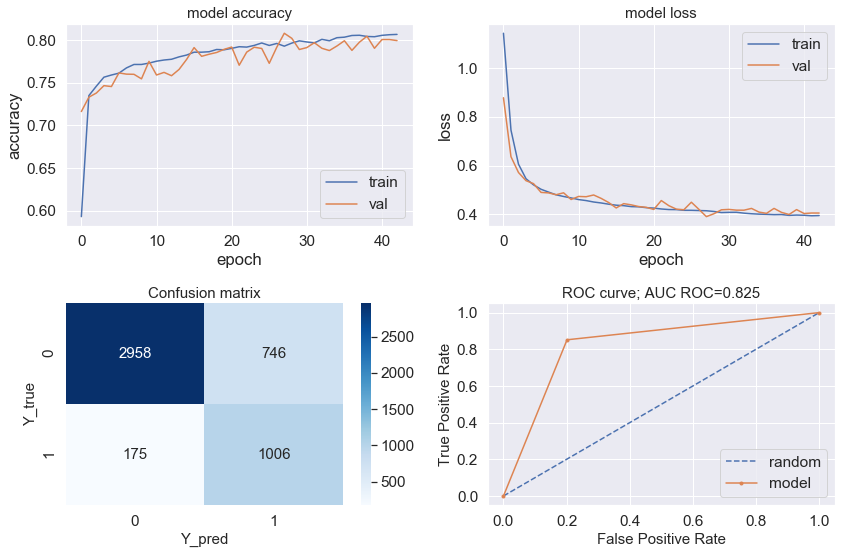

In [27]:
#Results Neural Network
print("Neural Network")

# Generate generalization metrics
score = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


#Confusion Matrix
# summarize history for accuracy

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy', fontsize = 15)
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='lower right')



# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss', fontsize = 15)
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')



#Generate predictions
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15},fmt='g', ax = ax3,cmap=plt.cm.Blues) # font size
ax3.set_title('Confusion matrix', fontsize = 15)
ax3.set_xlabel('Y_pred', fontsize = 15) # x-axis label with fontsize 15
ax3.set_ylabel('Y_true', fontsize = 15) # y-axis label with fontsize 15


##ROC AUC
# generate a no skill prediction (majority class)
y_pred_rd = [0 for _ in range(len(y_test))]

# calculate scores
rd_auc = roc_auc_score(y_test, y_pred_rd )
model_auc = roc_auc_score(y_test, y_pred)


# calculate roc curves
rd_fpr, rd_tpr, _ = roc_curve(y_test, y_pred_rd, pos_label= 1)
model_fpr, model_tpr, model_thresholds = roc_curve(y_test, y_pred, pos_label = 1)
# plot the roc curve for the model
ax4.plot(rd_fpr, rd_tpr, linestyle='--', label='random')
ax4.plot(model_fpr, model_tpr, marker='.', label='model')
ax4.set_xlabel('False Positive Rate', fontsize = 15)
ax4.set_ylabel('True Positive Rate', fontsize = 15)
ax4.set_title(f'ROC curve; AUC ROC=%.3f' % model_auc, fontsize = 15)
ax4.legend(loc='lower right')
plt.tight_layout()
